### Import all the things

In [1]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/brain_observatory_cache'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

In [2]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)




/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


### Get a test experiment and session

In [4]:
visual_area = 'VISp'
cre_line ='Emx1-IRES-Cre'

In [5]:
exps_df = pd.DataFrame(boc.get_experiment_containers(targeted_structures=[visual_area], cre_lines=[cre_line]))
exp_id = exps_df['id'][0]
print exp_id

561312433


In [71]:
session = boc.get_ophys_experiments(experiment_container_ids=[exp_id], stimuli=['natural_scenes'])
session_id = session[0]['id']
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)

### Get this session's analysis object

In [10]:
from allensdk.brain_observatory.natural_scenes import NaturalScenes

analysis_path = os.path.join(drive_path,'ophys_experiment_analysis')
analysis_file = os.path.join(analysis_path, str(session_id)+'_three_session_B_analysis.h5')

ns = NaturalScenes.from_analysis_file(data_set, analysis_file)

Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/561994407_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/561994407_three_session_B_analysis.h5 in read-only mode
Opening /data/dynamic-brain-workshop/brain_observatory_cache/ophys_experiment_analysis/561994407_three_session_B_analysis.h5 in read-only mode


#### Here's the old RSA

In [16]:
import scipy.stats as st

def get_representational_similarity(ns, corr='spearman'):

    response = ns.response[:, :, 0]
    response = response[:, :ns.numbercells]
    Nstim, N = response.shape

    rep_sim = np.zeros((Nstim, Nstim))
    rep_sim_p = np.empty((Nstim, Nstim))
    if corr == 'pearson':
        for i in range(Nstim):
            for j in range(i, Nstim): # matrix is symmetric
                rep_sim[i, j], rep_sim_p[i, j] = st.pearsonr(response[i], response[j])

    elif corr == 'spearman':
        for i in range(Nstim):
            for j in range(i, Nstim): # matrix is symmetric
                rep_sim[i, j], rep_sim_p[i, j] = st.spearmanr(response[i], response[j])

    else:
        raise Exception('correlation should be pearson or spearman')

    rep_sim = np.triu(rep_sim) + np.triu(rep_sim, 1).T # fill in lower triangle
    rep_sim_p = np.triu(rep_sim_p) + np.triu(rep_sim_p, 1).T  # fill in lower triangle

    return rep_sim, rep_sim_p


In [17]:
rep_sim, rep_sim_p = get_representational_similarity(ns)

True

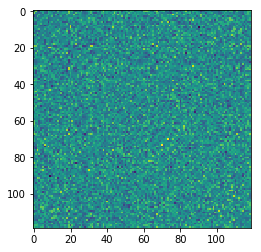

In [33]:
plt.imshow(rep_sim - np.eye(rep_sim.shape[0]))

np.allclose(rep_sim , ns.representational_similarity)

### Now let's write a new method

In [288]:
def get_representational_similarity_expanded(ns, corr='spearman', mean_sweep = True, which_trials = 'mean'):
    """Returns the Representational Similarity Matrix for this session of natural scene reponse.
    Input
    -----
    ns = NaturalScenes object
    
    Options
    -------
    
    corr = 'spearman' or 'pearson'. Type of correlation to use
    mean_sweep = True/False. Whether to use the mean sweep or, if false, the entire sweep
    which_trials = How to handle multiple showings of the same image. Options:
                    'mean' : use trial-average mean response
                    'random' : use a random trial for each neuron. destroys effects noise correlation in the RSM
                    'all' : string all trials together 
    
    """
    
    Nstim, N = ns.number_scenes, ns.numbercells
    N_trials = len(ns.stim_table)/Nstim

    
    if mean_sweep == True:
        if which_trials == 'mean':
            response = ns.response[:, :ns.numbercells, 0]
            
        elif which_trials == 'random':
            # first merge so we can select our choice of trial
            indexed_mean_sweep_response = pd.merge(ns.stim_table, ns.mean_sweep_response,
                     how='left', left_index=True, right_index =True)
            
            # awesome 1-liner to pick a random trial for each frame
            response = indexed_mean_sweep_response.groupby('frame').apply(
                        lambda x : x.iloc[np.random.randint(0,len(x))])
            
            # now drop the columns we picked up from stim_table. Also drop running response (last elem.)
            response = response.iloc[:,3:-1].values
            assert response.shape == (Nstim, N)
            
        elif which_trials == 'all':
        
            indexed_mean_sweep_response = pd.merge(ns.stim_table, ns.mean_sweep_response,
                     how='left', left_index=True, right_index =True)
            
            # the "response" to an frame will be the population reponse to each presentation of that frame,
            # concatenated
            response = np.zeros((Nstim, N * N_trials))
            for frame in range(Nstim):
                # get all the responses for a single frame. 
                this_frame = df.groupby('frame').get_group(frame-1)
                # drop stim_table columns and running resp.
                this_frame = this_frame.iloc[:,3:-1]
                
                response[frame] = this_frame.values.flatten()
            
        else:
            raise Exception('which_trials should be all, random, or mean.')
            
    elif mean_sweep == False:
        if which_trials == 'mean':
            avg_sweeps = get_avg_sweep(ns)
            # now unwrap
            response = unwrap_sweeps(sweep_df.iloc[:,:-1], ns)
            
        elif which_trials == 'random':
            avg_sweeps = get_rand_sweep(ns)
            # now unwrap
            response = unwrap_sweeps(sweep_df.iloc[:,:-1], ns)
        elif which_trials == 'all':
            # this super-gross operation returns a pd.Series of length number_scenes,
                # with each value being the concatenated all-trial, all-neuron, all-sweep response
            my_group = indexed_sweep_response.groupby('frame').apply(
                        lambda x: np.concatenate(
                                        [np.concatenate(
                                                x[str(neuron)].values) for neuron in range(N)]  ))
            
            # and then we turn it into an array
            response = np.array([r for r in my_group ])

            
        else:
            raise Exception('which_trials should be all, random, or mean.')   
    else:
        raise Exception('mean_sweep must be True or False')
            


    rep_sim = np.zeros((Nstim, Nstim))
    rep_sim_p = np.empty((Nstim, Nstim))
    if corr == 'pearson':
        for i in range(Nstim):
            for j in range(i, Nstim): # matrix is symmetric
                rep_sim[i, j], rep_sim_p[i, j] = st.pearsonr(response[i], response[j])

    elif corr == 'spearman':
        for i in range(Nstim):
            for j in range(i, Nstim): # matrix is symmetric
                rep_sim[i, j], rep_sim_p[i, j] = st.spearmanr(response[i], response[j])

    else:
        raise Exception('correlation should be pearson or spearman')

    rep_sim = np.triu(rep_sim) + np.triu(rep_sim, 1).T # fill in lower triangle
    rep_sim_p = np.triu(rep_sim_p) + np.triu(rep_sim_p, 1).T  # fill in lower triangle

    return rep_sim, rep_sim_p


In [227]:
def get_avg_sweep(ns):
    """Takes a NaturalScenes object and returns a dataframe of shape (numberscenes, numbercells)
    containing the sweep averaged over trials.
    """
    indexed_sweep_response = pd.merge(ns.stim_table, ns.sweep_response,
                     how='left', left_index=True, right_index =True)

    # awesome 1-liner to grab the average sweep for each frame
    response = indexed_sweep_response.groupby('frame').apply(
                              lambda x :x.mean())
    return response.iloc[:,3:]


In [228]:
def unwrap_sweeps(sweep_df, ns):
    """Takes a dataframe containing a sweep for each neuron and returns an 'unwrapped' numpy array,
    of shape (numberscenes, numbercells * N_trials)"""
    Nstim, N = ns.number_scenes, ns.numbercells
    sweep_len = len(sweep_df.iloc[0,0])
    
    unwrapped = np.zeros((Nstim, N * sweep_len))
    for frame in range(Nstim):
        # get all the responses for a single frame
        this_frame = np.hstack(sweep_df.iloc[frame])
        unwrapped[frame] = this_frame
        
    return unwrapped

In [229]:
def get_rand_sweep(ns):
    """Takes a NaturalScenes object and returns a dataframe of shape (numberscenes, numbercells)
    containing, for each neuron and frame, a random sweep from one of the trials.
    """
    indexed_sweep_response = pd.merge(ns.stim_table, ns.sweep_response,
                     how='left', left_index=True, right_index =True)

    # awesome 1-liner to grab a random sweep for each frame
    response = indexed_sweep_response.groupby('frame').apply(
                              lambda x :x.iloc[np.random.randint(0,len(x))])
    return response.iloc[:,3:]


In [293]:
my_group = indexed_sweep_response.groupby('frame').apply(
                        lambda x: np.concatenate(
                                        [np.concatenate(
                                                x[str(neuron)].values) for neuron in range(N)]  ))

In [282]:
rep_sim, rep_sim_p = get_representational_similarity_expanded(ns, corr='spearman',
                                                              mean_sweep=True, which_trials='mean')

True

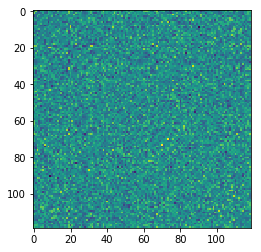

In [283]:
plt.imshow(rep_sim - np.eye(rep_sim.shape[0]))

np.allclose(rep_sim , ns.representational_similarity)

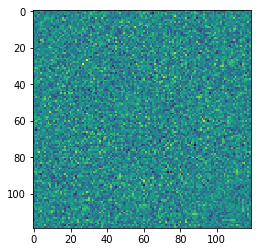

In [284]:
rep_sim, rep_sim_p = get_representational_similarity_expanded(ns, corr='spearman',
                                                              mean_sweep=True, which_trials='all')
plt.imshow(rep_sim - np.eye(rep_sim.shape[0]))


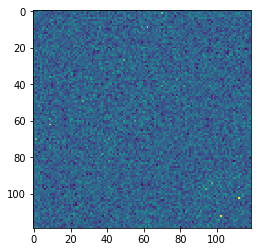

In [289]:
rep_sim, rep_sim_p = get_representational_similarity_expanded(ns, corr='spearman',
                                                              mean_sweep=True, which_trials='random')
plt.imshow(rep_sim - np.eye(rep_sim.shape[0]))

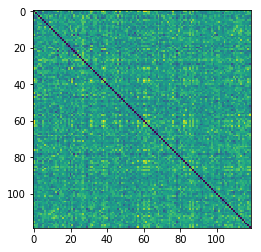

In [290]:
rep_sim, rep_sim_p = get_representational_similarity_expanded(ns, corr='spearman',
                                                              mean_sweep=False, which_trials='random')
plt.imshow(rep_sim - np.eye(rep_sim.shape[0]))

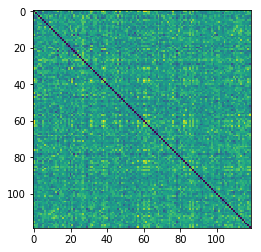

In [291]:
rep_sim, rep_sim_p = get_representational_similarity_expanded(ns, corr='spearman',
                                                              mean_sweep=False, which_trials='mean')
plt.imshow(rep_sim - np.eye(rep_sim.shape[0]))

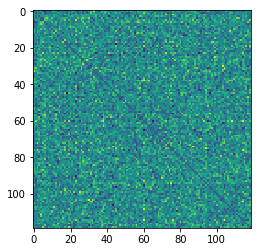

In [292]:
rep_sim, rep_sim_p = get_representational_similarity_expanded(ns, corr='spearman',
                                                              mean_sweep=False, which_trials='all')
plt.imshow(rep_sim - np.eye(rep_sim.shape[0]))


In [273]:
result = np.array([r for r in my_group ])
result.shape

(119, 661500)

In [231]:
sweep_df = get_avg_sweep(ns)
unwrap_sweeps(sweep_df.iloc[:,:-1], ns).shape

(119, 13230)

In [198]:
Nstim

119

In [145]:
print ns.number_scenes, ns.numbercells
print ns.stim_table.shape
print ns.mean_sweep_response.shape
df = pd.merge(ns.stim_table, ns.mean_sweep_response,how='left', left_index=True, right_index =True)
print ns.response[:,:ns.numbercells,0].shape
df_rand = df.groupby('frame').apply(
                        lambda x :x.iloc[np.random.randint(0,len(x))])
df_rand.iloc[:,3:-1].shape
df_avg = df.groupby('frame').apply(
                        lambda x :x.iloc[np.random.randint(0,len(x))])


response = np.zeros((Nstim, N * N_trials))
for frame in range(Nstim):
    response[frame] = df.groupby('frame').get_group(frame-1).iloc[:,3:-1].values.flatten()


119 210
(5950, 3)
(5950, 211)
(119, 210)


0

In [117]:
df.mean().shape

(214,)